In [1]:
import numpy as np

import matplotlib.pyplot as plt

import copy, time
import random

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 1500
signal_to_noise = 4


nsamples = 20
L = 10

# ranks = np.array([5, 4, 3, 3, 2, 2, 2, 2, 1])
# ranks = np.array([5, 5, 5, 4, 3, 3, 3, 3, 2, 1])
ranks = np.array([10, 10, 10, 4, 3, 3, 3, 3, 2, 1])

rank = ranks.sum()

In [4]:
pi_rows = np.arange(n) #np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
# for ngroups in [2, 5, 9, 17, 33, 65, 129, 257, n+1]:
for ngroups in [2, 5, 9, 17, 33, 65, 129, 257, 513, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=1500.0
level=1, num_groups=4, mean_size=375.0
level=2, num_groups=8, mean_size=187.5
level=3, num_groups=16, mean_size=93.8
level=4, num_groups=32, mean_size=46.9
level=5, num_groups=64, mean_size=23.4
level=6, num_groups=128, mean_size=11.7
level=7, num_groups=256, mean_size=5.9
level=8, num_groups=512, mean_size=2.9
level=9, num_groups=1500, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=48.19268668331124, noise_var=12.381246964085253
SNR=3.8923936194072835, signal_to_noise=4


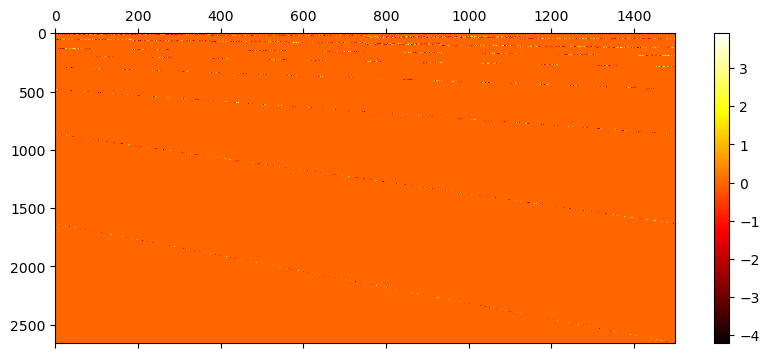

(1500, 2658)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [8]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=10, num_sparsities=512
(512, 9) [  0   3   7  15  31  63 127 255 511]


In [9]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]
v = np.random.randn(n)

In [10]:
def mlr_matvec(x0, B, C, D, F_hpart, ranks, sign=1):
    # Compute \tilde B @ \tilde C^T @ x0
    if len(x0.shape) == 1: x0 = x0.reshape(-1, 1)
    x = x0[F_hpart["pi"]]
    res = D[:, np.newaxis] * x
    for level in range(len(F_hpart["lk"])):
        lk = F_hpart["lk"][level]
        num_blocks = lk.size - 1 
        for block in range(num_blocks):
            r1, r2 = lk[block], lk[block+1]
            res[r1:r2] += sign * B[r1:r2, ranks[:level].sum():ranks[:level+1].sum()] @ \
                                (C[r1:r2, ranks[:level].sum():ranks[:level+1].sum()].T @ x[r1:r2])
    return res[F_hpart["pi_inv"]]

# Test matmul

In [11]:
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]


In [12]:
for _ in range(5):
    B_Lm1 = np.random.randn(n, ranks[:-1].sum())
    C_Lm1 = np.random.randn(n, ranks[:-1].sum())

    B = np.concatenate([B_Lm1, np.sqrt(D).reshape(-1, 1)], axis=1)
    C = np.concatenate([C_Lm1, np.sqrt(D).reshape(-1, 1)], axis=1)

    rand_mlr = mf.MLRMatrix(B=B, C=C, hpart=hpart, ranks=ranks)
    rand_mlr.construct_sparse_format()

    for _ in range(100):
        v = np.random.randn(n, 1)
        Av = mlr_matvec(v, B_Lm1, C_Lm1, D, F_hpart, ranks)
        reldiff = np.linalg.norm(Av - rand_mlr.matvec(v)) / np.linalg.norm(v)
        assert reldiff < 1e-12, print(f"{reldiff=}")
print("PASSED")

PASSED


In [13]:
def iter_refinement_intermediate_matrices(F_Lm1, B_Lm1, C_Lm1, D, F_hpart, ranks, si, si_groups, row_selectors):
    r1, r2 = row_selectors[si: si+2] # contiguous range for group si
    n = F_Lm1.shape[0]
    tilde_B_ci = mfm.get_sparse_F_si_col_sparsity(B_Lm1, ranks, F_hpart, si_groups[si]) # n x (r-1)
    assert tilde_B_ci.shape == (n, ranks[:-1].sum())

    Sigma_B_ci = mlr_matvec(tilde_B_ci, F_Lm1, F_Lm1, D, F_hpart, ranks) # n x (r-1)
    del tilde_B_ci
    ci_Bt_Sigma2_B_ci = Sigma_B_ci.T @ Sigma_B_ci

    Sigma2_B_ci = mlr_matvec(Sigma_B_ci, F_Lm1, F_Lm1, D, F_hpart, ranks) # n x (r-1)
    ri_Vt_ci_t = -Sigma_B_ci[r1:r2, :].T # (r-1) x (r2-r1) 
    del Sigma_B_ci
    Sigma_inv_t_Sigma2_B_ci = mlr_matvec(Sigma2_B_ci, C_Lm1, B_Lm1, 1/D, F_hpart, ranks, sign=-1) # n x (r-1)
    del Sigma2_B_ci
    ri_Vt_ci_t += Sigma_inv_t_Sigma2_B_ci[r1:r2, :].T # (r-1) x (r2-r1)
    return ri_Vt_ci_t, ci_Bt_Sigma2_B_ci, r1, r2


def delta_iterative_refinement(F_Lm1, B_Lm1, C_Lm1, D, F_hpart, ranks, si_groups, row_selectors, t=None):
    Delta = np.zeros(F_Lm1.shape)
    num_sparsities = row_selectors.size - 1
    for si in range(num_sparsities):
        ri_Vt_ci_t, ci_W_ci, r1, r2 = iter_refinement_intermediate_matrices(F_Lm1, B_Lm1, C_Lm1, D, F_hpart, 
                                                                            ranks, si, si_groups, row_selectors)
        Delta[r1:r2, :] = np.linalg.lstsq(ci_W_ci, ri_Vt_ci_t)[0].T
    return Delta


def sp_loss_iter_refinement(F_Lm1, B_Lm1, C_Lm1, D, F_hpart, ranks):
    tilde_F = mf.convert_compressed_to_sparse(F_Lm1, F_hpart, ranks[:-1])
    tilde_B = mf.convert_compressed_to_sparse(B_Lm1, F_hpart, ranks[:-1])
    tilde_C = mf.convert_compressed_to_sparse(C_Lm1, F_hpart, ranks[:-1])
    Sigma = tilde_F @ tilde_F.T + np.diag(D.flatten())
    Sigma_inv = - tilde_B @ tilde_C.T + np.diag((1/D).flatten())
    n = tilde_B.shape[0]
    return np.linalg.norm(Sigma @ Sigma_inv - np.eye(n), ord="fro") / np.sqrt(n), \
            np.linalg.norm(Sigma @ Sigma_inv.T - np.eye(n), ord="fro") / np.sqrt(n)


def als_iterative_refinement(F_Lm1, H_Lm1, D, F_hpart, ranks, si_groups, row_selectors, eps=1e-9, max_iter=20, printing=False):
    B_Lm1 = H_Lm1 + 0
    C_Lm1 =  H_Lm1 + 0
    t = 0 
    reldiff = sp_loss_iter_refinement(F_Lm1, B_Lm1, C_Lm1, D, F_hpart, ranks)
    if printing:
        print(f"{reldiff=}")
    while reldiff[0] > eps and t < max_iter:
        C_Lm1 += delta_iterative_refinement(F_Lm1, B_Lm1, C_Lm1, D, F_hpart, ranks, si_groups, row_selectors, t=t)
        B_Lm1 += delta_iterative_refinement(F_Lm1, C_Lm1, B_Lm1, D, F_hpart, ranks, si_groups, row_selectors, t=t)
        
        reldiff = sp_loss_iter_refinement(F_Lm1, B_Lm1, C_Lm1, D, F_hpart, ranks)
        if printing:
            print(f"{t=}, {reldiff=}")
        t += 1
    if printing and reldiff[0] > eps:
        print(f"terminated with {reldiff=}")
    return B_Lm1, C_Lm1

In [15]:
true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
true_mfm.inv_coefficients() 

H_Lm1 = true_mfm.H 
F_Lm1 = true_mfm.F 
D = true_mfm.D 


B_Lm1, C_Lm1 = als_iterative_refinement(F_Lm1, H_Lm1, D, F_hpart, ranks, si_groups, row_selectors, 
                                        eps=1e-16, max_iter=20, printing=True)

reldiff=(2.0922541104365586e-10, 2.0922541104365586e-10)


/var/folders/fp/rkwhsn_57zn3tz7fw_ct6s8m0000gn/T/ipykernel_81415/852664930.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Delta[r1:r2, :] = np.linalg.lstsq(ci_W_ci, ri_Vt_ci_t)[0].T


t=0, reldiff=(1.33298793461473e-07, 1.333351193142977e-08)
t=1, reldiff=(1.3216872657195845e-07, 1.429745771563198e-08)
t=2, reldiff=(1.9357449003182362e-07, 2.159186253035554e-08)
t=3, reldiff=(1.2755687435849074e-07, 1.1765700245180269e-08)
t=4, reldiff=(5.86321305993605e-08, 9.439750869244044e-09)
t=5, reldiff=(5.506807178393638e-08, 9.675622162284492e-09)
t=6, reldiff=(6.966028065470668e-08, 1.212044540980047e-08)
t=7, reldiff=(1.9311721669277749e-07, 2.555713714946831e-08)
t=8, reldiff=(1.5131954978325927e-07, 1.6414619696908394e-08)
t=9, reldiff=(8.786500061955624e-08, 1.1965335140959834e-08)
t=10, reldiff=(1.428605930407071e-07, 1.554514243507418e-08)
t=11, reldiff=(7.4813781742121e-08, 9.274550406797894e-09)
t=12, reldiff=(1.0567320037451574e-07, 1.0403693662635779e-08)
t=13, reldiff=(1.0646188120433052e-07, 1.4783250968203043e-08)
t=14, reldiff=(5.658991773088003e-08, 1.0726625678972287e-08)
t=15, reldiff=(1.081654846143428e-07, 1.1896356544116623e-08)
t=16, reldiff=(1.1430185